In [1]:
import torch
q_full = torch.load("subset_qk/block_1_q_proj_batch_6.pt")
k_full = torch.load("subset_qk/block_1_k_proj_batch_6.pt")

q = q_full[0]
k = k_full[0]

L, d_model = q.shape
num_heads  = 32 
d_head     = d_model // num_heads

# split into heads and pick head 0
q0 = q.view(L, num_heads, d_head).permute(1, 0, 2)[15]
k0 = k.view(L, num_heads, d_head).permute(1, 0, 2)[15]

q0 = q0 / 128 ** 0.25
k0 = k0 / 128 ** 0.25

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Settings
P = 8
D = 2000
d = 128


sample = 40

# Precompute phi_x
norm_x = np.zeros((sample))
phi_x = np.zeros((P, D))
w = np.where(np.random.rand(P, D, d) < 0.5, -1.0, +1.0)
pos = 200
x = np.array(q0[pos,:])
nx = np.linalg.norm(x)
x/=nx
for p in range(1, P+1):
    for j in range(D):
        scale = 1 / np.sqrt(D)               
        for i in range(p):
            scale *= np.dot(w[i, j], x)
        phi_x[p-1, j] = scale 

            
approx_vals = [] 
for i in range(sample):
    y = np.array(k0[i,:]) 
    ny = np.linalg.norm(np.array(k0[i,:]))
    y/=ny
    # Compute phi_y
    phi_y = np.zeros((P, D))
    for p in range(1, P+1):
        for j in range(D):
            scale = 1 / np.sqrt(D)
            for i in range(p):
                scale *= np.dot(w[i, j], y)
            phi_y[p-1, j] = scale
    # Approximate kernel
    approx_k = 1.0
    last_postive = 0.0
    for p in range(P):
        approx_k += abs(np.dot(phi_x[p], phi_y[p])) / math.factorial(p+1)
    approx_k = approx_k ** (nx * ny)
    approx_vals.append(approx_k)



In [5]:
x = np.array(q0[pos,:])
true_vals = []
sample = 40
for i in range(sample):
    y = np.array(k0[i,:]) 
    true_k = np.exp(np.dot(x, y))
    true_vals.append(true_k)

In [6]:
true_vals /= max(true_vals)
true_vals /= sum(true_vals)

In [7]:
approx_vals /= max(approx_vals)
approx_vals /= sum(approx_vals)

In [8]:
torch.norm(torch.tensor(true_vals) - torch.tensor(approx_vals)) / torch.norm(torch.tensor(true_vals))

tensor(0.0999, dtype=torch.float64)

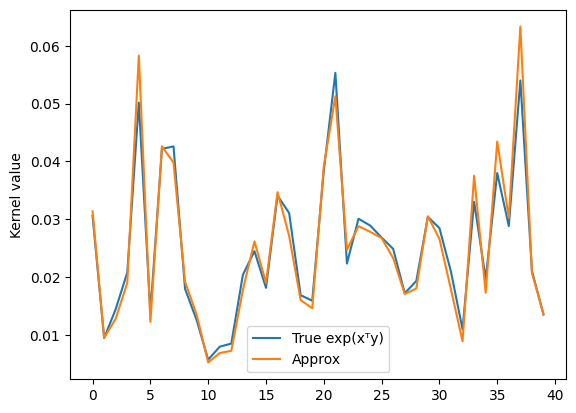

In [9]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(40)
s1 = 0
begin, end = s1 * 40, s1*4000 + 400
sample = 4096
# 4) plot
plt.figure()
plt.plot(x[begin:end], true_vals[begin:end],    label='True exp(xᵀy)')
plt.plot(x[begin:end], approx_vals[begin:end],  label='Approx')
plt.ylabel('Kernel value')
plt.legend()
plt.show()

# Precompute all


In [9]:
import numpy as np
import math
import torch

# ——— Load and prepare q0, k0 as NumPy arrays ———
q_full = torch.load("subset_qk/block_1_q_proj_batch_6.pt", map_location="cpu")
k_full = torch.load("subset_qk/block_1_k_proj_batch_6.pt", map_location="cpu")

q = q_full[0]  # shape [L, d_model]
k = k_full[0]

L, d_model = q.shape
num_heads  = 32
d_head     = d_model // num_heads

# pick head 15 and first `sample` positions
sample = 4096
def sampling(q, k, sample):
    q0 = (
        q
        .view(L, num_heads, d_head)
        .permute(1, 0, 2)[15, :sample]
        .numpy()
    )   # shape [sample, d_head]
    k0 = (
        k
        .view(L, num_heads, d_head)
        .permute(1, 0, 2)[15, :sample]
        .numpy()
    )

    q0 = q0 / 128 ** 0.25
    k0 = k0 / 128 ** 0.25
    
    return q0, k0


def rfattention(q0, k0, P, D, d):
    # normalize each vector and keep norms
    norm_x = np.linalg.norm(q0, axis=1, keepdims=True)  # [sample,1]
    norm_y = np.linalg.norm(k0, axis=1, keepdims=True)
    X = q0 / norm_x    # [sample, d]
    Y = k0 / norm_y

    # ——— Random ±1 weights ———
    P, D, d = 8, 2000, d_head
    w = np.where(np.random.rand(P, D, d) < 0.5, -1.0, 1.0)  # [P, D, d]

    proj_x = np.einsum('sd,pfd->spf', X, w)  
    proj_y = np.einsum('sd,pfd->spf', Y, w)


    phi_x = (1.0 / np.sqrt(D)) * np.cumprod(proj_x, axis=1)  # [sample, P, D]
    phi_y = (1.0 / np.sqrt(D)) * np.cumprod(proj_y, axis=1)

    # ——— Approximate kernel between all pairs ———
    # 1) compute per-degree cross‐dots: Kp[p,i,j] = φ_x[i,p]·φ_y[j,p]
    Kp = np.einsum('ipd,jpd->pij', phi_x, phi_y)  # [P, sample, sample]

    # 2) weight by 1/(p+1)! and sum over p
    factorials = np.array([math.factorial(p+1) for p in range(P)]).reshape(P,1,1)
    S = np.sum(Kp / factorials, axis=0)    # [sample, sample]

    # 3) apply (1 + S)^( norm_x * norm_yᵀ)
    exponents = (norm_x * norm_y.T)               # [sample, sample]
    approx = np.power(1.0 + S, exponents)

    # 4) row‐normalize (divide by row max, then by row sum)
    row_max = approx.max(axis=1, keepdims=True)
    approx = approx / row_max
    approx = approx / approx.sum(axis=1, keepdims=True)

    # result
    record_approx_values = approx  # [sample, sample]
    return record_approx_values

def true_softmax(q0, k0):
    x = np.array(q0[:sample,:])
    y = np.array(k0[:sample,:])

    dot = np.matmul(x, y.T)
    true_val = np.exp(dot - dot.max(axis=1, keepdims=True))
    true_val /= true_val.sum(axis=1, keepdims=True)
    return true_val

def report_error(record_approx_values, true_val):
    return torch.norm(torch.tensor(record_approx_values - true_val)) / torch.norm(torch.tensor(true_val))



# Usage 

In [ ]:
P, D, d = 8, 2000, 128
sample=4096  
q0, k0 = sampling(q, k, sample)
record_approx_values = rfattention(q0, k0, P, D, d)
true_val = true_softmax(q0, k0)

In [15]:
import torch
torch.norm(torch.tensor(record_approx_values - true_val)) / torch.norm(torch.tensor(true_val))

tensor(0.1062, dtype=torch.float64)

# Draw plot 

In [23]:
P, D, d = 8, 2000, 128
sample=40
q0, k0 = sampling(q, k, sample)
record_approx_values = rfattention(q0, k0, P, D, d)
true_val = true_softmax(q0, k0)

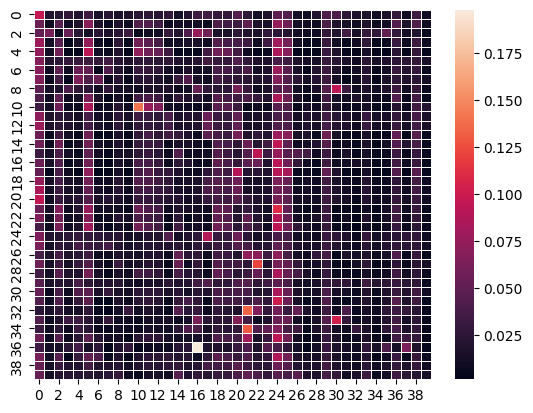

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt


ax = sns.heatmap(true_val, linewidth=0.5)
plt.show()

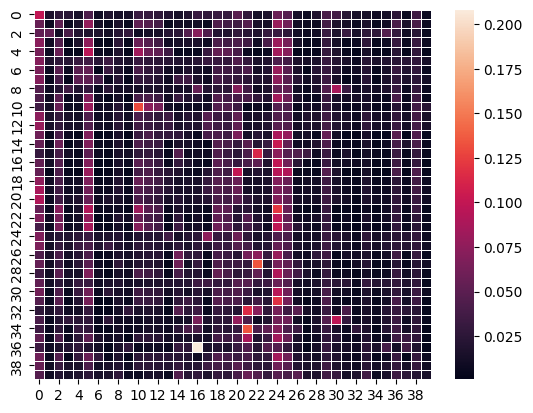

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt


ax = sns.heatmap(record_approx_values, linewidth=0.5)
plt.show()

In [26]:
report_error(record_approx_values, true_val)

tensor(0.1178, dtype=torch.float64)